In [ ]:
# if sb3 gives you trouble, try this:
# uv pip install stable_baselines3

In [4]:
import torch

torch.cuda.is_available()

True

In [1]:
# automatically reload modules before execution
%reload_ext autoreload
%autoreload 2

import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import time

import supersuit as ss
import torch
from pettingzoo.mpe import simple_spread_v3
from pettingzoo.utils.conversions import aec_to_parallel
from stable_baselines3 import PPO
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.vec_env import VecMonitor

import wandb

# Import from MARL_library
from marl_library.visualization import (
    create_training_dashboard_gif,
    create_training_history_gif,
)

## Set up the env

In [2]:
# Number of agents
num_agents = 4

# create the PettingZoo environment
env = simple_spread_v3.env(
    N=num_agents, local_ratio=0.5, max_cycles=100, continuous_actions=False
)  # N of agents, partial global vs local reward mixing

# Apply wrappers
env = ss.black_death_v3(env)  # keeps a dummy agent alive when one is done
env = ss.flatten_v0(env)  # flatten observations for SB3 compatibility
env = aec_to_parallel(env)  # Convert AECEnv to ParallelEnv
env = ss.pettingzoo_env_to_vec_env_v1(env)  # convert to vectorized env
env = ss.concat_vec_envs_v1(
    env, 1, num_cpus=1, base_class="stable_baselines3"
)  # Use SB3 base class
env = VecMonitor(env)  # to record metrics easily

## Initialize env

In [3]:
# get free API key from wandb.ai
# wandb.tensorboard.patch(root_logdir="./ppo_marl_tb/") # patch TensorBoard logging
wandb.init(
    project="marl-coordination-demo", name="PPO-simple-spread", sync_tensorboard=True
)

wandb: Currently logged in as: anastasiia-chernavskaia (anastasiia-chernavskaia-barcelona-school-of-economics) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Train agents

In [5]:
policy_kwargs = dict(
    net_arch=[256, 256, 128],
    activation_fn=torch.nn.Tanh,
)

model = PPO(
    ActorCriticPolicy,
    env=env,
    learning_rate=3e-4,
    n_steps=256,
    batch_size=512,
    ent_coef=0.005,
    gamma=0.98,
    gae_lambda=0.95,
    verbose=1,
    tensorboard_log="./ppo_marl_tb/",
    policy_kwargs=policy_kwargs
)

model.learn(total_timesteps=50000)  # number of timesteps to train
model.save("ppo_marl_simple_spread")
wandb.finish()

Using cuda device
Logging to ./ppo_marl_tb/PPO_28
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -139     |
| time/              |          |
|    fps             | 979      |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 1024     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 101         |
|    ep_rew_mean          | -153        |
| time/                   |             |
|    fps                  | 926         |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 2048        |
| train/                  |             |
|    approx_kl            | 0.005580035 |
|    clip_fraction        | 0.0156      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.61       |
|    explained_varianc

global_step,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇████
rollout/ep_len_mean,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
rollout/ep_rew_mean,▄▁▁▁▂▁▁▂▁▂▂▂▁▂▂▄▃▃▃▅▆▆▇▆▆█▇▇▆▇▆▆▄▄▅▆▅▅▄▅
time/fps,▅▄▅▆▆▇▇▇▇███████████▇▇▆▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁
train/approx_kl,▃▁▁▁▁▁▁▁▃▂▁▁▂▁▂▄▂▂▂▄▂▄▄▁█▁▁▂▁▄▂▂▁▂▂▂▁▂▁▄
train/clip_fraction,▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▅▁▂▃▁█▁▁▁▁▂▁▁▁▁▁▁▁▂▁▄
train/clip_range,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/entropy_loss,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▅▄▄▅▅▆▇█▇▆█▆▇▅▅▅▆▅▅▅▅▅▆▆
train/explained_variance,▅▆▄▆▅▅▄▇▅▅█▄▅▇▆▅▁▄▅▅▅▅▅▅▅▆▆▅▅▅▅▅▃▆▆▄▆▆▆▆
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,▅█▄▆▄▃▂▇▃▂▇▄▄▂▃▁▅▁▂▁▃▁▂▂▁▁▃▁▄▁▂▃▂▂▂▁▁▂▂▂


## Visualize training history

In [10]:
# Set up evaluation environment and wrappers
num_agents = 4
eval_env = simple_spread_v3.env(
    N=num_agents, local_ratio=0.5, max_cycles=100, continuous_actions=False, render_mode=None
)
eval_env = ss.pad_observations_v0(eval_env)
eval_env = ss.flatten_v0(eval_env)
eval_env.reset(seed=42)

# Extract fixed landmark positions after reset
landmark_positions = [l.state.p_pos for l in eval_env.unwrapped.world.landmarks]

# Load trained model
model = PPO.load("ppo_marl_simple_spread")

frames = []

# Maintain latest observations for all agents
agent_obs_dict = {
    agent: np.zeros(eval_env.observation_space(agent).shape, dtype=np.float32)
    for agent in eval_env.possible_agents
}

for agent in eval_env.agent_iter():
    obs, reward, terminated, truncated, info = eval_env.last()
    if terminated or truncated:
        action = None
    else:
        agent_obs_dict[agent] = obs  # Update this agent's observation
        # Concatenate all agents' observations in a consistent order
        obs_array = np.array(obs, dtype=np.float32)
        action, _ = model.predict(obs_array, deterministic=True)
        # If action is an array of shape (1,), convert to int
        if isinstance(action, np.ndarray) and action.shape == (1,):
            action = int(action)
        elif np.isscalar(action):
            action = int(action)
    eval_env.step(action)

    # Get agent positions
    agent_positions = [a.state.p_pos for a in eval_env.unwrapped.world.agents]

    # Plot frame
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_facecolor('white')
    ax.axis('off')
    ax.set_xlim(-1, 1.4)
    ax.set_ylim(-1.5, 0.9)
    ax.set_aspect('equal')

    # Plot landmarks (fixed)
    for i, pos in enumerate(landmark_positions):
        ax.scatter(*pos, c='black', s=150, marker='o', label='Landmark' if i == 0 else "")

    # Plot agents
    for i, pos in enumerate(agent_positions):
        ax.scatter(*pos, c='blue', s=400, marker='o', alpha=0.7, edgecolors='white', linewidths=2, label='Agent' if i == 0 else "")

    # Legend (horizontal, smaller markers)
    ax.legend(loc='upper center', ncol=3, fontsize=10, bbox_to_anchor=(0.5, 1.1), markerscale=0.5)

    # Convert plot to image
    fig.canvas.draw()
    argb_str = fig.canvas.tostring_argb()
    width, height = fig.canvas.get_width_height()
    argb = np.frombuffer(argb_str, dtype=np.uint8).reshape((height, width, 4))
    rgb = argb[:, :, 1:4]  # Drop alpha, keep RGB
    frames.append(rgb)
    plt.close(fig)

# Save as GIF
os.makedirs('figures', exist_ok=True)
imageio.mimsave('figures/simple_spread_trained.gif', frames, fps=10)
print("Animation saved to figures/simple_spread_trained.gif")

Animation saved to figures/simple_spread_trained.gif


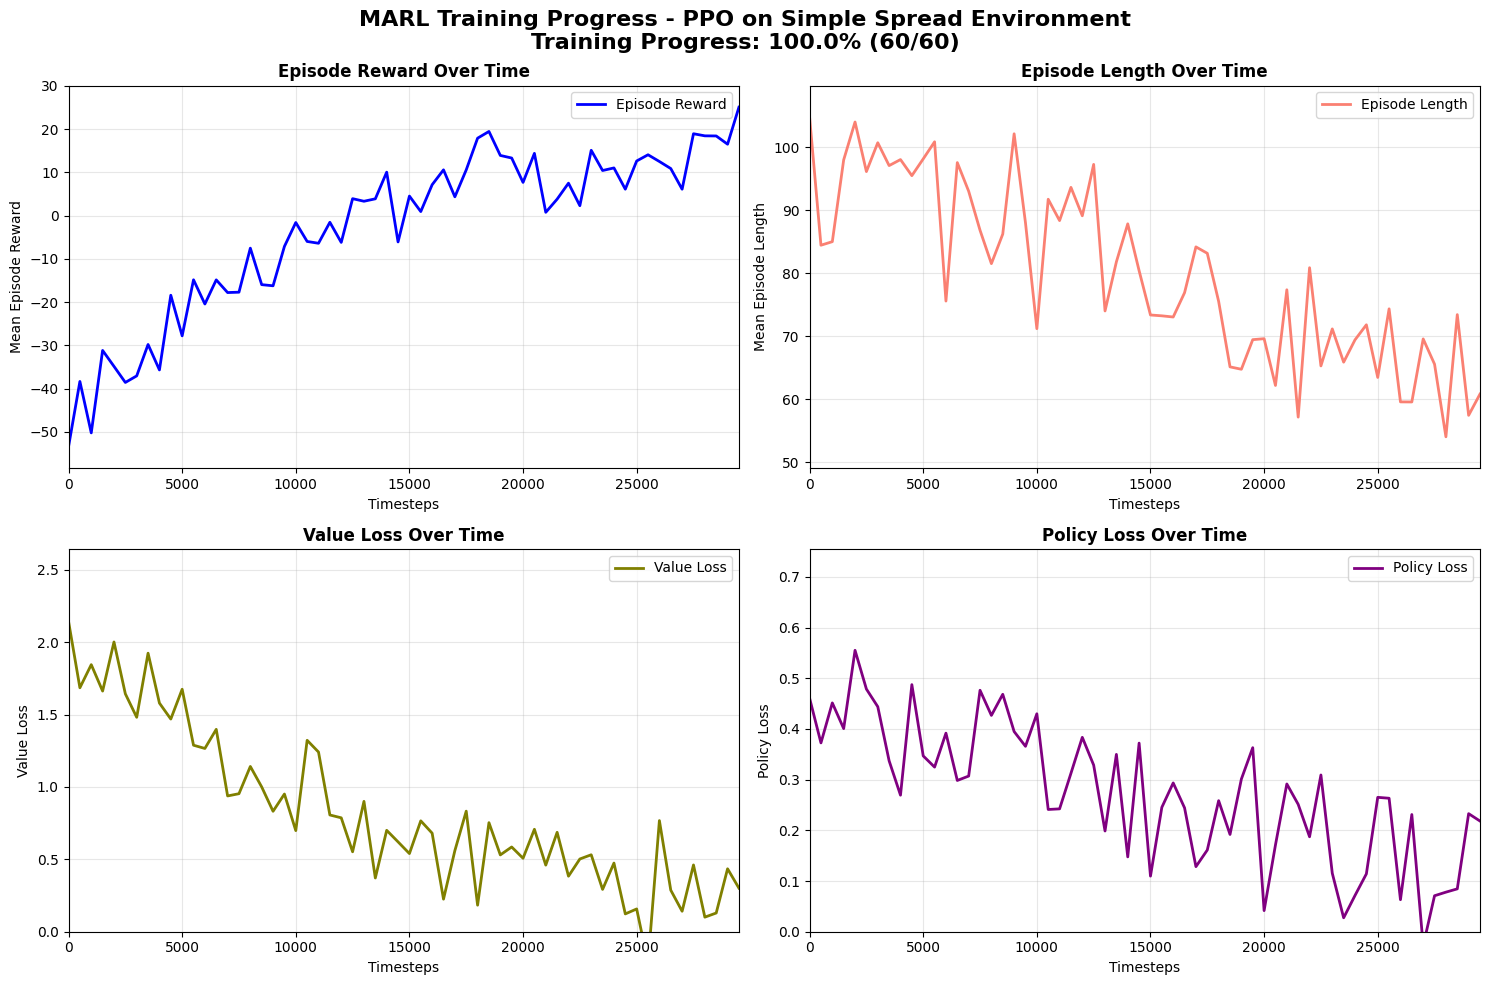

In [18]:
# visualize rewards, episode length, value loss and policu loss over time
gif_file = create_training_history_gif()

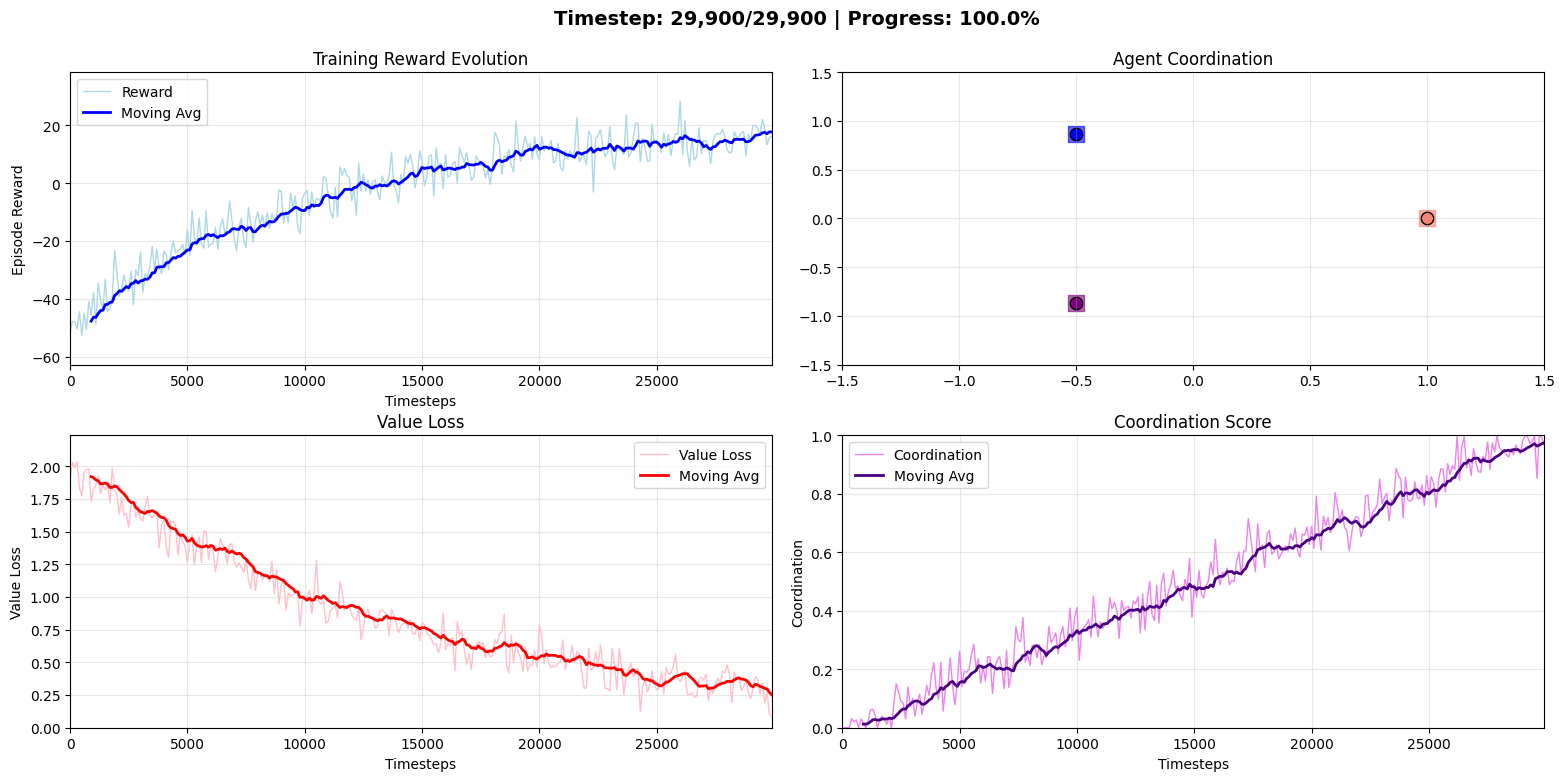

In [19]:
# visualize the evolution of rewards with moving avg, coordination score and movement of agents
create_training_dashboard_gif()

## Test trained agents

In [ ]:
# Load the trained model
model = PPO.load("ppo_marl_simple_spread")

# Create a clean environment for testing (with rendering enabled)
test_env = simple_spread_v3.env(
    N=num_agents,
    local_ratio=0.5,
    max_cycles=100,
    continuous_actions=False,
    render_mode="human",
)
test_env = ss.black_death_v3(test_env)
test_env = ss.flatten_v0(test_env)
test_env = aec_to_parallel(test_env)
test_env = ss.pettingzoo_env_to_vec_env_v1(test_env)
test_env = ss.concat_vec_envs_v1(
    test_env, 1, num_cpus=1, base_class="stable_baselines3"
)

print("Testing trained agents...")
obs = test_env.reset()
for i in range(100):  # Run for 50 steps
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = test_env.step(action)
    test_env.render()  # This will show the visualization
    time.sleep(0.1)  # Slow down for better visualization

    if dones.all():
        obs = test_env.reset()
        print(f"Episode finished at step {i}")

test_env.close()

Testing trained agents...
